conifer, decidious

In [1]:
%load_ext autoreload
%autoreload 2

import tifffile as tiff
import numpy as np
import rasterio
import matplotlib
import matplotlib.pyplot as plt
import sys

import geojson
from rasterio.mask import mask
from osgeo import gdal, osr
from rasterio.plot import plotting_extent

from rasterio import features
from shapely import geometry
from shapely.geometry import Polygon, MultiPolygon

import pandas as pd
import json
import re
import subprocess
from os import listdir
from pyproj import Proj, transform

import scipy
import cv2
from glob import glob

In [131]:
sys.path.insert(0, '../')
from preprocessing_scripts.dataset_preprocessing import save_bbox, write_tif_mask, extract_coord, img_extention, crop_aoi, img_extention2geojson, band_resize, crop_resize

In [4]:
geojson_fn = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/vydels.geojson'

In [5]:
with open(geojson_fn, 'r+', encoding="utf-8") as f:
    gj = geojson.load(f)

In [10]:
! gdalinfo '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/0_channel_0.tif'

Driver: GTiff/GeoTIFF
Files: /home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/0_channel_0.tif
Size is 4751, 15590
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (45.814619540000002,61.572230848939995)
Pixel Size = (0.000017732662594,-0.000017732662594)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  45.8146195,  61.5722308) ( 45d48'52.63"E, 61d34'20.03"N)
Lower Left  (  45.8146195,  61.2957786) ( 45d48'52.63"E, 61d17'44.80"N)
Upper Right (  45.8988674,  61.5722308) ( 45d53'55.92"E, 61d34'20.03"N)
Lower Right (  45.8988674,  61.2957786) ( 45d53'55.92"E, 61d17'44.80"N)
Center      (  45.8567435,  61.4340047) ( 45d51'24.28"E, 61d26'

In [110]:
! gdalinfo '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A007297_20180730T081559/B02_10m_norm.tif'

Driver: GTiff/GeoTIFF
Files: /home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A007297_20180730T081559/B02_10m_norm.tif
Size is 4710, 2707
Coordinate System is:
PROJCS["WGS 84 / UTM zone 38N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",45],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32638"]]
Origin = (

In [113]:
with rasterio.open('/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A007297_20180730T081559/B02_10m_norm.tif') as src:
    tmp = src.read(1)
    print(src.crs)

EPSG:32638


### Change geojson crs

In [115]:
# for sentinel 
current_crs = 4326
target_crs = 32638
dist_geojson = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/vydels.geojson'
source_geojson = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/vydels_31012020.geojson'
! ogr2ogr -f "GeoJSON" $dist_geojson $source_geojson -s_srs EPSG:$current_crs -t_srs EPSG:$target_crs 

### Check intersection between lidar and markup

In [221]:
def read_geojson(geojson_fn):
    with open(geojson_fn, encoding="utf-8") as src:
        gj = geojson.loads(src.read())

    conifer_polys = []
    decidious_polys = []
    conifer_height = []
    decidious_height = []
    conifer_age = []
    decidious_age = []
    conifer_sp = ['Е', 'С']
    decidious_sp = ['Б', 'ОС']
    
    for ind, feature in enumerate(gj.features):
        if feature['geometry']['type'] == 'MultiPolygon':
            for pol in feature['geometry']['coordinates']:
                if len(pol) == 1:
                    if feature['properties']['first_spec'] in conifer_sp:
                        conifer_polys.append(Polygon(pol[0], holes = None))
                        conifer_height.append(int(feature['properties']['MEAN_HGW']))
                        conifer_age.append(int(feature['properties']['MEAN_AGE']))
                    elif feature['properties']['first_spec'] in decidious_sp:
                        decidious_polys.append(Polygon(pol[0], holes = None)) 
                        decidious_height.append(int(feature['properties']['MEAN_HGW']))
                        decidious_age.append(int(feature['properties']['MEAN_AGE']))
                else:
                    holes = []
                    for hole in pol[1:]:
                        holes.append(hole) 
                    if feature['properties']['first_spec'] in conifer_sp:
                        conifer_polys.append(Polygon(pol[0], holes = holes)) 
                        conifer_height.append(int(feature['properties']['MEAN_HGW']))
                        conifer_age.append(int(feature['properties']['MEAN_AGE']))
                    elif feature['properties']['first_spec'] in decidious_sp:
                        decidious_polys.append(Polygon(pol[0], holes = holes)) 
                        decidious_height.append(int(feature['properties']['MEAN_HGW']))
                        decidious_age.append(int(feature['properties']['MEAN_AGE']))
        else:
            if len(feature['geometry']['coordinates']) == 1:
                if feature['properties']['first_spec'] in conifer_sp:
                    conifer_polys.append(Polygon(feature['geometry']['coordinates'][0], holes = None)) 
                    conifer_height.append(int(feature['properties']['MEAN_HGW']))
                    conifer_age.append(int(feature['properties']['MEAN_AGE']))
                elif feature['properties']['first_spec'] in decidious_sp:
                    decidious_polys.append(Polygon(feature['geometry']['coordinates'][0], holes = None))  
                    decidious_height.append(int(feature['properties']['MEAN_HGW']))
                    decidious_age.append(int(feature['properties']['MEAN_AGE']))
            else:
                holes = []
                for hole in feature['geometry']['coordinates'][1:]:
                    holes.append(hole) #[0]
                if feature['properties']['first_spec'] in conifer_sp:
                    conifer_polys.append(Polygon(feature['geometry']['coordinates'][0], holes = holes))
                    conifer_height.append(int(feature['properties']['MEAN_HGW']))
                    conifer_age.append(int(feature['properties']['MEAN_AGE']))
                elif feature['properties']['first_spec'] in decidious_sp:
                    decidious_polys.append(Polygon(feature['geometry']['coordinates'][0], holes = holes)) 
                    decidious_height.append(int(feature['properties']['MEAN_HGW']))
                    decidious_age.append(int(feature['properties']['MEAN_AGE']))
                
    return conifer_polys, decidious_polys, conifer_height, decidious_height, conifer_age, decidious_age

### Split into conifer and decidious polygons

In [ ]:
with open(save_file, 'r') as f:
    js_tmp = json.load(f)

### Save polygons to tif masks

1. worldview

In [222]:
geojson_fn = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/vydels_31012020.geojson'
conifer_polys, decidious_polys, conifer_height, decidious_height, conifer_age, decidious_age = read_geojson(geojson_fn)

In [60]:
len(decidious_polys), len(conifer_polys), len(decidious_height), len(conifer_height), len(decidious_age), len(conifer_age)

(1561, 3197, 1561, 3197, 1561, 3197)

In [62]:
# check polys
crs = {
        "type": "name",
        "properties": {
            "name": "EPSG:4326"
        }
    }    

output_geojson = 'decidious_polys.geojson'
feature_collection = geojson.FeatureCollection([{"geometry":poly, 
                                                 "properties":{"height":height,
                                                              "age":age}} 
                                                for poly, height, age in zip(decidious_polys, 
                                                                        decidious_height, decidious_age)], crs=crs)
with open(output_geojson, 'w') as f:
    geojson.dump(feature_collection, f)

output_geojson = 'conifer_polys.geojson'    
feature_collection = geojson.FeatureCollection([{"geometry":poly, 
                                                 "properties":{"height":height,
                                                              "age":age}} 
                                                for poly, height, age in zip(conifer_polys,
                                                                        conifer_height, conifer_age)], crs=crs)
with open(output_geojson, 'w') as f:
    geojson.dump(feature_collection, f)


In [96]:
# save classes masks
for img_ind in range(2):    
    rst_fn = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_channel_0.tif'.format(img_ind)
    for sp_class, polys in zip(["conifer", "decidious"], [conifer_polys, decidious_polys]):
        out_fn = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_{}.tif'.format(img_ind, sp_class)

        write_tif_mask(rst_fn, out_fn, polys)

        save_json_file = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_{}.json'.format(img_ind, sp_class)
        save_bbox(rst_fn, polys, save_json_file)

In [223]:
# save 
for img_ind in range(4):    
    rst_fn = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_channel_0.tif'.format(img_ind)
    for sp_class, polys in zip(["conifer", "decidious"], [conifer_polys, decidious_polys]):
        #out_fn = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_{}.tif'.format(img_ind, sp_class)

        #write_tif_mask(rst_fn, out_fn, polys)

        save_json_file = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_{}.json'.format(img_ind, sp_class)
        save_bbox(rst_fn, polys, save_json_file)

In [107]:
# save age and height
for img_ind in range(2):    
    rst_fn = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_channel_0.tif'.format(img_ind)
    polys = conifer_polys + decidious_polys
    age = conifer_age + decidious_age
    height = conifer_height + decidious_height
    
    out_fn = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_age.tif'.format(img_ind)
    write_tif_mask(rst_fn, out_fn, polys, age)
    
    out_fn = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_height.tif'.format(img_ind)
    write_tif_mask(rst_fn, out_fn, polys, height)

In [108]:
with rasterio.open(out_fn, 'r') as src:
    tmp = src.read(1)

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f6b1b71b2e8>)

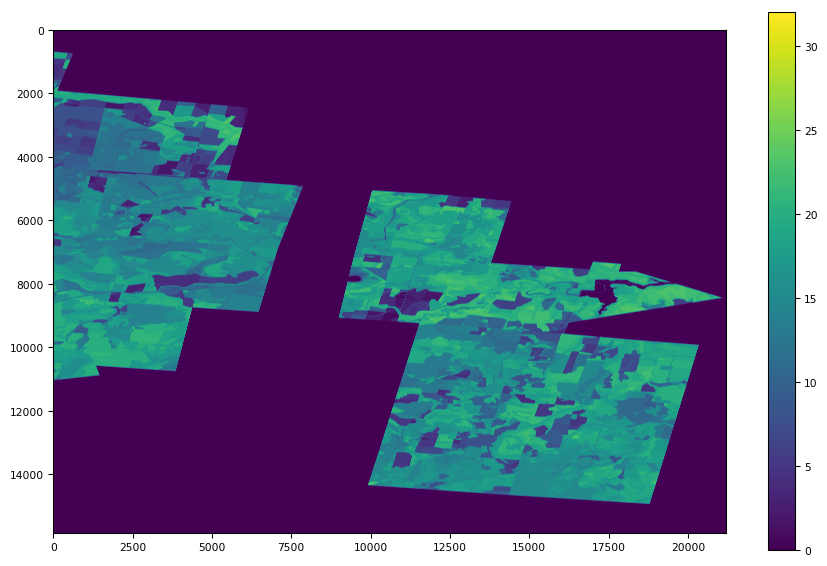

In [109]:
tiff.imshow(tmp)

In [100]:
imgpath = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/1_decidious.tif'
with rasterio.open(imgpath) as src:
    mask = src.read(1)
                

In [97]:
with open(save_json_file, 'r') as f:
    js_tmp = json.load(f)

In [98]:
js_tmp

{'0': {'upper_left_x': 13403,
  'upper_left_y': 9190,
  'pol_width': 220,
  'pol_height': 182,
  'pix_area': 7.97095747464299e-06},
 '1': {'upper_left_x': 11902,
  'upper_left_y': 5681,
  'pol_width': 893,
  'pol_height': 345,
  'pix_area': 6.827370632822096e-05},
 '2': {'upper_left_x': 10509,
  'upper_left_y': 5518,
  'pol_width': 254,
  'pol_height': 152,
  'pix_area': 3.5374868323798876e-06},
 '3': {'upper_left_x': 10270,
  'upper_left_y': 5506,
  'pol_width': 415,
  'pol_height': 223,
  'pix_area': 1.3875842174031908e-05},
 '4': {'upper_left_x': 9984,
  'upper_left_y': 6549,
  'pol_width': 457,
  'pol_height': 102,
  'pix_area': 5.525553706154241e-06},
 '5': {'upper_left_x': 9789,
  'upper_left_y': 6212,
  'pol_width': 106,
  'pol_height': 96,
  'pix_area': 1.9855291946404222e-06},
 '6': {'upper_left_x': 9587,
  'upper_left_y': 6350,
  'pol_width': 500,
  'pol_height': 352,
  'pix_area': 2.154056085526503e-05},
 '7': {'upper_left_x': 10081,
  'upper_left_y': 6774,
  'pol_width': 12

2. Sentinel

In [234]:
geojson_fn = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/vydels.geojson'
conifer_polys, decidious_polys, conifer_height, decidious_height, conifer_age, decidious_age = read_geojson(geojson_fn)

In [117]:
len(decidious_polys), len(conifer_polys), len(decidious_height), len(conifer_height), len(decidious_age), len(conifer_age)

(1561, 3197, 1561, 3197, 1561, 3197)

In [121]:
# save classes masks
for img_ind in ['L2A_T38VNP_A005695_20160725T082012',
               'L2A_T38VNP_A007297_20180730T081559',
               'L2A_T38VNP_A010986_20170730T082009',
               'L2A_T38VNP_A013017_20190903T081606',
               'L2A_T38VNP_A015748_20180628T082602',
               'L2A_T38VNP_A016606_20180827T083208']:    
    rst_fn = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/B02_10m_norm.tif'.format(img_ind)
    for sp_class, polys in zip(["conifer", "decidious"], [conifer_polys, decidious_polys]):
        out_fn = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/{}.tif'.format(img_ind, sp_class)

        write_tif_mask(rst_fn, out_fn, polys)

        save_json_file = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/{}.json'.format(img_ind, sp_class)
        save_bbox(rst_fn, polys, save_json_file)

In [235]:
# save classes masks
for img_ind in ['0',
               '1',
               '2',
               '3']:    
    rst_fn = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A007297_20180730T081559/val/{}_B02_10m_norm.tif'.format(img_ind)
    for sp_class, polys in zip(["conifer", "decidious"], [conifer_polys, decidious_polys]):
        save_json_file = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A007297_20180730T081559/val/{}_{}.json'.format(img_ind, sp_class)
        save_bbox(rst_fn, polys, save_json_file)

In [119]:
# save age and height
for img_ind in ['L2A_T38VNP_A005695_20160725T082012',
               'L2A_T38VNP_A007297_20180730T081559',
               'L2A_T38VNP_A010986_20170730T082009',
               'L2A_T38VNP_A013017_20190903T081606',
               'L2A_T38VNP_A015748_20180628T082602',
               'L2A_T38VNP_A016606_20180827T083208']:    
    rst_fn = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/B02_10m_norm.tif'.format(img_ind)
    polys = conifer_polys + decidious_polys
    age = conifer_age + decidious_age
    height = conifer_height + decidious_height
    
    out_fn = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/age.tif'.format(img_ind)
    write_tif_mask(rst_fn, out_fn, polys, age)
    
    out_fn = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/height.tif'.format(img_ind)
    write_tif_mask(rst_fn, out_fn, polys, height)

In [122]:
with open(save_json_file, 'r') as f:
    js_tmp = json.load(f)

In [123]:
js_tmp

{'0': {'upper_left_x': 4062,
  'upper_left_y': 814,
  'pol_width': 20,
  'pol_height': 35,
  'pix_area': 47401.249339548114},
 '1': {'upper_left_x': 3912,
  'upper_left_y': 121,
  'pol_width': 83,
  'pol_height': 68,
  'pix_area': 405217.0787004555},
 '2': {'upper_left_x': 3780,
  'upper_left_y': 91,
  'pol_width': 23,
  'pol_height': 30,
  'pix_area': 20992.500862940007},
 '3': {'upper_left_x': 3757,
  'upper_left_y': 89,
  'pol_width': 39,
  'pol_height': 44,
  'pix_area': 82343.51135388551},
 '4': {'upper_left_x': 3732,
  'upper_left_y': 295,
  'pol_width': 43,
  'pol_height': 20,
  'pix_area': 32807.60840931531},
 '5': {'upper_left_x': 3713,
  'upper_left_y': 229,
  'pol_width': 10,
  'pol_height': 19,
  'pix_area': 11787.123462500884},
 '6': {'upper_left_x': 3695,
  'upper_left_y': 256,
  'pol_width': 47,
  'pol_height': 69,
  'pix_area': 127897.01413295948},
 '7': {'upper_left_x': 3742,
  'upper_left_y': 340,
  'pol_width': 11,
  'pol_height': 28,
  'pix_area': 14134.413273961514

### Extract validation region extention

In [3]:
import os
os.listdir('/home/user/data/krasnoborsk/world_view/0')

['3_3_pan.tif',
 'file_0_0.tif',
 'height_7_0.tif',
 '1_0_channel_1.tif',
 '7_0_pan.tif',
 'height_1_0_modified_cp.tif.aux.xml',
 '2_0_channel_0.tif',
 '2_4_pan.tif',
 '6_2_channel_0.tif',
 '2_1_pan.tif',
 '3_1_channel_0.tif',
 '2_0_class_606.tif',
 '7_0_channel_1.tif',
 '6_3_channel_0.tif',
 'height_6_1_sh.tif',
 '6_4_class_606.tif',
 '2_2_channel_3.tif',
 '2_4_channel_2.tif',
 '0_0_line.tif',
 '3_2_pan.tif',
 '2_3_line.tif',
 '6_3_class_606.tif.aux.xml',
 'file_0_2.tif',
 '1_0_pan.tif',
 '2_0_channel_3.tif',
 '7_4_channel_2.tif',
 '6_4_channel_1.tif',
 'height_4_5_sh.tif',
 '4_2_channel_0.tif',
 '2_1_class_606.tif',
 'height_0_2_modified_pr.tif',
 '7_2_channel_0.tif',
 '1_1_pan_modified.tif.aux.xml',
 '3_3_class_606.tif',
 '1_0_pan.tif.aux.xml',
 '2_0_channel_1.tif',
 '0_2_class_606.tif',
 'height_5_3.tif',
 '0_2_channel_1.tif',
 '6_3_pan.tif',
 '5_3_channel_3.tif',
 '5_4_pan.tif',
 '6_0_channel_2.tif',
 'height_2_0.tif',
 'height_2_3_sh.tif',
 '6_3_channel_2.tif',
 '1_1_channel_0.ti

In [103]:
# validation region
for ind in ['1_1', '2_2', '4_2', '6_3']:
    imgpath = '/home/user/data/krasnoborsk/world_view/0/{}_channel_0.tif'.format(ind)
    window_x0, window_y0, window_x1, window_y1, _, _ = img_extention(imgpath) #extract_coord(imgpath)
    break

In [104]:
from shapely.geometry import Polygon, box
geom = box(window_x0, window_y0, window_x1, window_y1)
geom = [list(geom.exterior.coords)]

In [107]:
crs = {
        "type": "name",
        "properties": {
            "name": "EPSG:" + str(current_crs)
        }
    }    
    
feature_collection = geojson.FeatureCollection([{'geometry':{'type': 'Polygon', 'coordinates':geom}}], crs=crs)
with open('tmp.geojson', 'w') as f:
    geojson.dump(feature_collection, f)

In [106]:
# change crs 
from shapely.geometry import Polygon, box
current_crs = 4326
target_crs = 32638
reprojected_geom = rasterio.warp.transform_geom(rasterio.crs.CRS.from_epsg(current_crs), 
                                                        rasterio.crs.CRS.from_epsg(target_crs), 
                                                        {'type': 'Polygon', 'coordinates': geom})

In [97]:
crs = {
        "type": "name",
        "properties": {
            "name": "EPSG:" + str(target_crs)
        }
    }    
    
feature_collection = geojson.FeatureCollection([{'geometry':reprojected_geom}], crs=crs)
with open('tmp.geojson', 'w') as f:
    geojson.dump(feature_collection, f)

In [108]:
x_coord = [pair_xy[0] for pair_xy in np.asarray(reprojected_geom['coordinates'][0])]
y_coord = [pair_xy[1] for pair_xy in np.asarray(reprojected_geom['coordinates'][0])]

Upper_Left_x = np.min(x_coord)
Lower_Right_x = np.max(x_coord)
Upper_Left_y = np.max(y_coord)
Lower_Right_y = np.min(y_coord)
val_region = (Upper_Left_x, Upper_Left_y, Lower_Right_x, Lower_Right_y)

In [114]:
def coord2pix(source_img_path, val_region):
    Upper_Left_x, Upper_Left_y, Lower_Right_x, Lower_Right_y, dx, dy = img_extention(source_img_path)
    #print(dx, dy)
    dy = abs(dy)
    Upper_Left_x_val, Upper_Left_y_val, Lower_Right_x_val, Lower_Right_y_val = val_region
    if Upper_Left_x > Lower_Right_x_val or Lower_Right_y > Upper_Left_y_val:
        print('does not intersect')
        return
    Upper_Left_x_new = max(0, Upper_Left_x_val - Upper_Left_x) // dx
    Upper_Left_y_new = max(0, Upper_Left_y - Upper_Left_y_val) // dy
    
    if Lower_Right_x - Lower_Right_x_val > 0:
        size_x_new = (Lower_Right_x_val - max(Upper_Left_x, Upper_Left_x_val)) // dx 
    else:
        size_x_new = (Lower_Right_x - max(Upper_Left_x, Upper_Left_x_val)) // dx
        
    if Lower_Right_y_val - Lower_Right_y > 0:
        size_y_new = (Upper_Left_y_val - Lower_Right_y_val) // dy 
    else:
        size_y_new = (Upper_Left_y_val - Lower_Right_y) // dy 
        
    return Upper_Left_x_new, Upper_Left_y_new, size_x_new, size_y_new

In [117]:
#for img_ind in ['L2A_T38VNP_A005695_20160725T082012']:
               #'L2A_T38VNP_A007297_20180730T081559',
               #'L2A_T38VNP_A010986_20170730T082009',
               #'L2A_T38VNP_A013017_20190903T081606',
               #'L2A_T38VNP_A015748_20180628T082602',
               #'L2A_T38VNP_A016606_20180827T083208']:  
    # validation region
img_ind = 'L2A_T38VNP_A005695_20160725T082012'
ext_dict = {}
key = 0
for ind in ['1_1', '2_2', '4_2', '6_3']:
    imgpath = '/home/user/data/krasnoborsk/world_view/0/{}_channel_0.tif'.format(ind)
    window_x0, window_y0, window_x1, window_y1, _, _ = img_extention(imgpath) #extract_coord(imgpath)
    
    geom = box(window_x0, window_y0, window_x1, window_y1)
    geom = [list(geom.exterior.coords)]
    
    current_crs = 4326
    target_crs = 32638
    reprojected_geom = rasterio.warp.transform_geom(rasterio.crs.CRS.from_epsg(current_crs), 
                                                        rasterio.crs.CRS.from_epsg(target_crs), 
                                                        {'type': 'Polygon', 'coordinates': geom})
    
    x_coord = [pair_xy[0] for pair_xy in np.asarray(reprojected_geom['coordinates'][0])]
    y_coord = [pair_xy[1] for pair_xy in np.asarray(reprojected_geom['coordinates'][0])]

    Upper_Left_x = np.min(x_coord)
    Lower_Right_x = np.max(x_coord)
    Upper_Left_y = np.max(y_coord)
    Lower_Right_y = np.min(y_coord)
    val_region = (Upper_Left_x, Upper_Left_y, Lower_Right_x, Lower_Right_y)

    source_img_path = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/B02_10m_norm.tif'.format(img_ind) 
    Upper_Left_x_new, Upper_Left_y_new, size_x_new, size_y_new = coord2pix(source_img_path, val_region)
    
    ext_dict[key] = {"upper_left_x": Upper_Left_x_new, "upper_left_y": Upper_Left_y_new, 
                             "pol_width": size_x_new, "pol_height": size_y_new}
    key += 1
    
save_file = 'val_region.json'
with open(save_file, 'w') as f:
    json.dump(ext_dict, f)

In [111]:
source_img_path

'/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A016606_20180827T083208/B02_10m_norm.tif'

In [112]:
tmp = tiff.imread('/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A016606_20180827T083208/B07_10m_norm.tif')
tmp.shape

(2707, 4710)

In [56]:
! gdalinfo $source_img_path

Driver: GTiff/GeoTIFF
Files: /home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A005695_20160725T082012/B02_10m_norm.tif
Size is 4710, 2707
Coordinate System is:
PROJCS["WGS 84 / UTM zone 38N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",45],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32638"]]
Origin = (

In [64]:
tmp = (tmp - np.min(tmp))/(np.max(tmp)-np.min(tmp))

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7fdf1fee3630>)

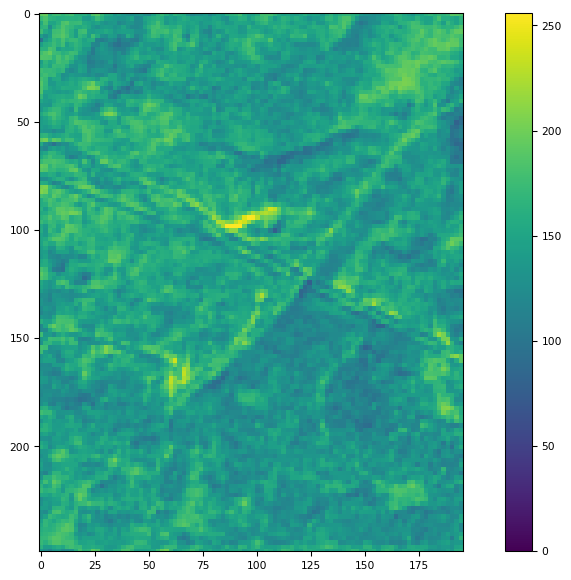

In [113]:
tiff.imshow(tmp[234:234+249,3818:3818+196])

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7fdef33b6860>)

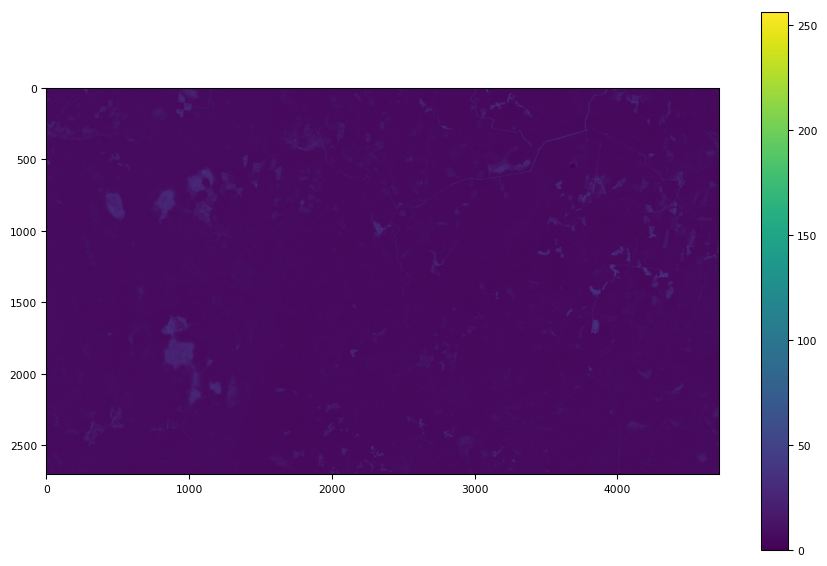

In [55]:
tiff.imshow(tmp)

### Save lidar markup

In [ ]:
# gdal_merge.py output.tif input1.tif input2.tif

1. world view

In [125]:
! gdalinfo '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/0_channel_0.tif'

Driver: GTiff/GeoTIFF
Files: /home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/0_channel_0.tif
Size is 4751, 15590
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (45.814619540000002,61.572230848939995)
Pixel Size = (0.000017732662594,-0.000017732662594)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  45.8146195,  61.5722308) ( 45d48'52.63"E, 61d34'20.03"N)
Lower Left  (  45.8146195,  61.2957786) ( 45d48'52.63"E, 61d17'44.80"N)
Upper Right (  45.8988674,  61.5722308) ( 45d53'55.92"E, 61d34'20.03"N)
Lower Right (  45.8988674,  61.2957786) ( 45d53'55.92"E, 61d17'44.80"N)
Center      (  45.8567435,  61.4340047) ( 45d51'24.28"E, 61d26'

In [126]:
! gdalinfo '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/out.tif'

Driver: GTiff/GeoTIFF
Files: /home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/out.tif
Size is 38661, 29840
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (45.167463925494587,61.577329115739609)
Pixel Size = (0.000018889982711,-0.000008920138108)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  45.1674639,  61.5773291) ( 45d10' 2.87"E, 61d34'38.38"N)
Lower Left  (  45.1674639,  61.3111522) ( 45d10' 2.87"E, 61d18'40.15"N)
Upper Right (  45.8977695,  61.5773291) ( 45d53'51.97"E, 61d34'38.38"N)
Lower Right (  45.8977695,  61.3111522) ( 45d53'51.97"E, 61d18'40.15"N)
Center      (  45.5326167,  61.4442407) ( 45d31'57.42"E, 61d26'39.27"N)
Band 1 Blo

In [175]:
input_file = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/out.tif'
for ind in ['0', '1']:
    geojson_path = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_extention.geojson'.format(ind)
    extention_img_path = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_channel_0.tif'.format(ind)
    current_crs = 4326
    img_extention2geojson(extention_img_path, geojson_path, current_crs)
    output_file = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_lidar.tif'.format(ind)
    crop_aoi(input_file=input_file, output_file=output_file, geojson_file=geojson_path, crs=current_crs)

In [187]:
for ind in ['0', '1']:
    geojson_path = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_extention_new.geojson'.format(ind)
    extention_img_path = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_lidar.tif'.format(ind)
    current_crs = 4326
    img_extention2geojson(extention_img_path, geojson_path, current_crs)
    input_file = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_channel_0.tif'.format(ind)
    output_file = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_channel_0_new.tif'.format(ind)
    crop_aoi(input_file=input_file, output_file=output_file, geojson_file=geojson_path, crs=current_crs, output_type=gdal.GDT_Float32)

In [188]:
for ind in ['0', '1']:
    geojson_path = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_extention_new.geojson'.format(ind)
    imgpath = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_lidar.tif'.format(ind)
    new_img = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_lidar_new.tif'.format(ind)
    target_size_imgpath = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_channel_0_new.tif'.format(ind)
    #geojson_path = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_extention.geojson'.format(ind)
    crop_resize(imgpath, target_size_imgpath, new_img, geojson_path, current_crs)

(14724, 4690) 4690 14724
(14974, 21126) 21126 14974


In [189]:
for ind in ['0', '1']:
    imgpath = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_lidar.tif'.format(ind)
    new_img = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_lidar_new.tif'.format(ind)
    target_size_imgpath = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_channel_0.tif'.format(ind)
    geojson_path = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_extention.geojson'.format(ind)
    crop_resize(imgpath, target_size_imgpath, new_img, geojson_path, current_crs)

(15590, 4751) 4751 15590
(15839, 21187) 21187 15839


In [186]:
! gdalinfo $new_img

Driver: GTiff/GeoTIFF
Files: /home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/1_lidar_new.tif
       /home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/1_lidar_new.tif.aux.xml
Size is 21126, 14974
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (45.522597240000003,61.577073730025148)
Pixel Size = (0.000017759611930,-0.000017759611930)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  45.5225972,  61.5770737) ( 45d31'21.35"E, 61d34'37.47"N)
Lower Left  (  45.5225972,  61.3111413) ( 45d31'21.35"E, 61d18'40.11"N)
Upper Right (  45.8977868,  61.5770737) ( 45d53'52.03"E, 61d34'37.4

2. sentinel

In [193]:
! gdalinfo '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A016606_20180827T083208/B02_10m_norm.tif'

Driver: GTiff/GeoTIFF
Files: /home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A016606_20180827T083208/B02_10m_norm.tif
Size is 4710, 2707
Coordinate System is:
PROJCS["WGS 84 / UTM zone 38N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",45],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32638"]]
Origin = (

In [190]:
os.listdir('/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk')

['L2A_T38VNP_A016606_20180827T083208',
 'birch_05.geojson',
 'L2A_T38VNP_A010986_20170730T082009',
 'spruce_05.geojson',
 'extention.geojson',
 '.ipynb_checkpoints',
 'L2A_T38VNP_A005695_20160725T082012',
 'L2A_T38VNP_A007297_20180730T081559',
 'pine_05.geojson',
 'vydels.geojson',
 'L2A_T38VNP_A015748_20180628T082602',
 'aspen_05.geojson',
 'L2A_T38VNP_A013017_20190903T081606']

In [194]:
input_file = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/out.tif'
for ind in ['L2A_T38VNP_A016606_20180827T083208',
     'L2A_T38VNP_A010986_20170730T082009',
     'L2A_T38VNP_A005695_20160725T082012',
     'L2A_T38VNP_A007297_20180730T081559',
     'L2A_T38VNP_A015748_20180628T082602',
     'L2A_T38VNP_A013017_20190903T081606']:
    geojson_path = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/extention.geojson'.format(ind)
    extention_img_path = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/B02_10m_norm.tif'.format(ind)
    current_crs = 32638
    img_extention2geojson(extention_img_path, geojson_path, current_crs)
    output_file = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/lidar.tif'.format(ind)
    crop_aoi(input_file=input_file, output_file=output_file, geojson_file=geojson_path, crs=current_crs)

In [195]:
for ind in ['L2A_T38VNP_A016606_20180827T083208',
     'L2A_T38VNP_A010986_20170730T082009',
     'L2A_T38VNP_A005695_20160725T082012',
     'L2A_T38VNP_A007297_20180730T081559',
     'L2A_T38VNP_A015748_20180628T082602',
     'L2A_T38VNP_A013017_20190903T081606']:
    geojson_path = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/extention_new.geojson'.format(ind)
    extention_img_path = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/lidar.tif'.format(ind)
    current_crs = 32638
    img_extention2geojson(extention_img_path, geojson_path, current_crs)
    input_file = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/B02_10m_norm.tif'.format(ind)
    output_file = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/B02_10m_norm_new.tif'.format(ind)
    crop_aoi(input_file=input_file, output_file=output_file, geojson_file=geojson_path, crs=current_crs, output_type=gdal.GDT_Float32)

In [196]:
for ind in ['L2A_T38VNP_A016606_20180827T083208',
     'L2A_T38VNP_A010986_20170730T082009',
     'L2A_T38VNP_A005695_20160725T082012',
     'L2A_T38VNP_A007297_20180730T081559',
     'L2A_T38VNP_A015748_20180628T082602',
     'L2A_T38VNP_A013017_20190903T081606']:
    geojson_path = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/extention_new.geojson'.format(ind)
    imgpath = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/lidar.tif'.format(ind)
    new_img = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/lidar_new.tif'.format(ind)
    target_size_imgpath = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/B02_10m_norm_new.tif'.format(ind)
    crop_resize(imgpath, target_size_imgpath, new_img, geojson_path, current_crs)

(1982, 3819) 3819 1982
(1982, 3819) 3819 1982
(1982, 3819) 3819 1982
(1982, 3819) 3819 1982
(1982, 3819) 3819 1982
(1982, 3819) 3819 1982


In [208]:
for ind in ['L2A_T38VNP_A016606_20180827T083208',
     'L2A_T38VNP_A010986_20170730T082009',
     'L2A_T38VNP_A005695_20160725T082012',
     'L2A_T38VNP_A007297_20180730T081559',
     'L2A_T38VNP_A015748_20180628T082602',
     'L2A_T38VNP_A013017_20190903T081606']:
    input_file = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/B02_10m_norm.tif'.format(ind)
    output_file = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/black.tif'.format(ind)
    geojson_file = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/extention.geojson'.format(ind)
    crop_aoi(input_file, output_file, geojson_file, output_type=gdal.GDT_Byte, crs=32638, value=0)
    
    output = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/lidar_new.tif'.format(ind)
    input1 = output_file
    input2 = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/{}/lidar.tif'.format(ind)
    #! cp $input2 $output
    ! gdal_merge.py $output $input1 $input2
    ! rm $output_file
    
    ! cp 'out.tif' $input2
    #! rm $output

ERROR 4: /home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A016606_20180827T083208/lidar_new.tif: No such file or directory
0...10...20...30...40...50...60...70...80...90...100 - done.
ERROR 4: /home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A010986_20170730T082009/lidar_new.tif: No such file or directory
0...10...20...30...40...50...60...70...80...90...100 - done.
ERROR 4: /home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A005695_20160725T082012/lidar_new.tif: No such file or directory
0...10...20...30...40...50...60...70...80...90...100 - done.
ERROR 4: /home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A007297_20180730T081559/lidar_new.tif: No such file or directory
0...10...20...30...40...50...60...70...80...90...100 - done.
ERROR 4: /ho

In [ ]:
! gdal_merge.py output.tif input1.tif input2.tif

## Predict classification with generated data WV

In [241]:
current_crs = 4326
geojson_path = '/home/user/data/krasnoborsk/yandex_val/ext.geojson'
imgpath = '/home/user/data/krasnoborsk/yandex_val/height_0.tif'
img_extention2geojson(current_crs=current_crs, geojson_path=geojson_path, imgpath=imgpath)

source_dir = '/home/user/data/krasnoborsk/yandex_val/'
for file_name in ['0_channel_0', '0_channel_1', '0_channel_2']:
    input_file = source_dir + file_name + '.tif'
    output_file = source_dir + file_name + '_new.tif'
    crop_aoi(input_file=input_file, output_file=output_file, geojson_file=geojson_path, crs=current_crs, output_type=gdal.GDT_Float32)


## Predict classification with generated data

In [210]:
# create geojson extention
dir_path = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/val/'
for img_name in ['1_1_pred.tif', '2_2_pred.tif', '4_2_pred.tif', '6_3_pred.tif']:
    current_crs = 4326
    img_extention2geojson(dir_path+img_name, geojson_path=dir_path+img_name.split('.')[0]+'.geojson',
                          current_crs=current_crs)

In [216]:
img_name[:-4]

'6_3_'

In [215]:
# crop channels and species types mask using extention
source_dir = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/'
for img_name in ['1_1_pred', '2_2_pred', '4_2_pred', '6_3_pred']:
    geojson_path = dir_path+img_name+'.geojson'
    for file_name in ['0_channel_0', '0_channel_1', '0_channel_2', '0_channel_3',
                     '0_channel_4', '0_channel_5', '0_channel_6', '0_channel_7',
                     '1_channel_0', '1_channel_1', '1_channel_2', '1_channel_3',
                     '1_channel_4', '1_channel_5', '1_channel_6', '1_channel_7',
                     '0_decidious', '0_conifer', '1_decidious', '1_conifer']:
        input_file = source_dir + file_name + '.tif'
        output_file = dir_path + img_name[:-4] + file_name[2:] + '.tif'
        try:
            crop_aoi(input_file=input_file, output_file=output_file, geojson_file=geojson_path, crs=current_crs, output_type=gdal.GDT_Float32)
        except:
            print(input_file)

/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/0_channel_0.tif
/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/0_channel_1.tif
/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/0_channel_2.tif
/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/0_channel_3.tif
/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/0_channel_4.tif
/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/0_channel_5.tif
/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/0_channel_6.tif
/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/0_channel_7.tif
/home/us

In [217]:
# resize pred from 1m to 2m
for img_name in ['1_1_pred', '2_2_pred', '4_2_pred', '6_3_pred']:
    geojson_path = dir_path+img_name+'.geojson'
    imgpath = dir_path + img_name + '.tif'
    target_size_imgpath = dir_path + img_name[:-4] + 'channel_0.tif'
    new_img = dir_path + img_name + '_new.tif'
    crop_resize(imgpath, target_size_imgpath, new_img, geojson_path, current_crs)

(1272, 2105) 2105 1272
(1272, 2108) 2108 1272
(1272, 2107) 2107 1272
(1274, 2110) 2110 1274


In [218]:
! gdalinfo $target_size_imgpath

Driver: GTiff/GeoTIFF
Files: /home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/val/6_3_channel_0.tif
Size is 2110, 1274
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (45.788245515242551,61.355682407711100)
Pixel Size = (0.000017759611930,-0.000017759611930)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  45.7882455,  61.3556824) ( 45d47'17.68"E, 61d21'20.46"N)
Lower Left  (  45.7882455,  61.3330567) ( 45d47'17.68"E, 61d19'59.00"N)
Upper Right (  45.8257183,  61.3556824) ( 45d49'32.59"E, 61d21'20.46"N)
Lower Right (  45.8257183,  61.3330567) ( 45d49'32.59"E, 61d19'59.00"N)
Center      (  45.8069819,  61.3443695) ( 45d48'25.13"E, 6

In [219]:
! gdalinfo $new_img

Driver: GTiff/GeoTIFF
Files: /home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/val/6_3_pred_new.tif
Size is 2110, 1274
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (45.788245515242551,61.355682407711100)
Pixel Size = (0.000017759611930,-0.000017759611930)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  45.7882455,  61.3556824) ( 45d47'17.68"E, 61d21'20.46"N)
Lower Left  (  45.7882455,  61.3330567) ( 45d47'17.68"E, 61d19'59.00"N)
Upper Right (  45.8257183,  61.3556824) ( 45d49'32.59"E, 61d21'20.46"N)
Lower Right (  45.8257183,  61.3330567) ( 45d49'32.59"E, 61d19'59.00"N)
Center      (  45.8069819,  61.3443695) ( 45d48'25.13"E, 61

sentinel

In [233]:
for ind in ['0', '1', '2', '3']:
    geojson_path = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A007297_20180730T081559/val/{}_extention.geojson'.format(ind)
    current_crs = 32638
    for file in ['conifer', 'decidious', 'height', 'lidar', 'B02_10m_norm',
                'B03_10m_norm','B04_10m_norm','B05_10m_norm','B06_10m_norm',
                'B07_10m_norm','B08_10m_norm','B8A_10m_norm','B11_10m_norm','B12_10m_norm']:
        input_file = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A007297_20180730T081559/val/{}.tif'.format(file)
        output_file = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A007297_20180730T081559/val/{}_{}.tif'.format(ind, file)
        crop_aoi(input_file=input_file, output_file=output_file, geojson_file=geojson_path, crs=current_crs, output_type=gdal.GDT_Float32)

In [230]:
file

'conifer'

In [237]:
for ind in ['0', '1', '2', '3']:
    geojson_path = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A007297_20180730T081559/val/{}_extention.geojson'.format(ind)
    current_crs = 32638
    
    input_file = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/arctic_dem.tif'
    output_file = '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A007297_20180730T081559/val/{}_arcticdem.tif'.format(ind, file)
    crop_aoi(input_file=input_file, output_file=output_file, geojson_file=geojson_path, crs=current_crs)